### Задача uplift-моделирования

In [1]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml


     |████████████████████████████████| 64.4MB 61kB/s 
     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 20.1MB 241kB/s 
     |████████████████████████████████| 327kB 22.6MB/s 
     |████████████████████████████████| 1.8MB 22.6MB/s 
     |████████████████████████████████| 634kB 19.7MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493670 sha256=c9b34a6134d0cf8785f8bfa4e4778e284b03738ac7f3f0b45c788a68c1969173
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465046 sha256=cff2c275386008b50059c790dd7f91254b07c916032a2caee022fe11f6f08848
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is 

In [2]:
from google.colab import drive
import numpy as np
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
path = '/gdrive/MyDrive/uplift_data/'

In [4]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df_clients = pd.read_csv(path +'data.csv')
df_clients.index.name ="client_id"

In [5]:
df_clients.rename(columns = {'conversion':'target', 'offer':'treatment_flg'}, inplace = True) 

In [6]:
df_clients.treatment_flg.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment_flg, dtype: int64

In [7]:
dct = {'Discount': 1, 'Buy One Get One': 1, 'No Offer': 0}
df_clients['treatment_flg'] = df_clients['treatment_flg'].map(dct)
df_clients['treatment_flg']

client_id
0        1
1        0
2        1
3        1
4        1
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: treatment_flg, Length: 64000, dtype: int64

In [8]:
#df_clients["active user"] = np.where(df_clients.used_discount + df_clients.used_bogo > 1, 1, 0)


In [9]:
# df_train = pd.read_csv(path +'uplift_train.csv', index_col='client_id')
# df_test = pd.read_csv(path +'uplift_test.csv', index_col='client_id')
#df_test.drop[]

# Извлечение признаков
df_features = df_clients.copy()
df_features = df_features.drop(['treatment_flg', 'target'], axis=1)

# В качестве новой фичи возьммем людей, которые были активны и использовали обе возможности получения скидки, и просто "скидка", и "Boy one Get One", считаем их активными
df_features["active user"] = np.where(df_features.used_discount + df_features.used_bogo > 1, 1, 0)
df_features = df_features.drop(['used_discount', 'used_bogo'], axis=1)

df_train, df_test, y_train, y_test = train_test_split(df_clients, df_clients[['target']], test_size=0.33, random_state=42)
df_test = df_train.copy()
df_train = df_train.drop(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel'], axis=1)
df_test = df_test.drop(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'treatment_flg', 'target'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [13]:
df_test.head(3)

""
client_id
44233
58749
56296


In [14]:
df_train

,treatment_flg,target
client_id,,
44233,1,0
58749,0,0
56296,1,0
23444,1,0
48936,1,0
...,...,...
62570,1,0
38158,1,0
860,1,0


In [15]:
df_train.groupby("treatment_flg")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,14222.0,0.108213,0.310660,0.0,0.0,0.0,0.0,1.0
1,28658.0,0.166481,0.372518,0.0,0.0,0.0,0.0,1.0


In [16]:
df_clients.groupby("treatment_flg")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


Заведем переменные

In [17]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['channel', 'zip_code']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [18]:
df_features.head()

,recency,history,zip_code,is_referral,channel,active user
client_id,,,,,,
0,10,142.44,Surburban,0,Phone,0
1,6,329.08,Rural,1,Web,1
2,7,180.65,Surburban,1,Web,0
3,9,675.83,Rural,1,Web,0
4,2,45.34,Urban,0,Web,0


In [19]:
treat_train

client_id
27052    1
55266    1
15305    0
20535    1
62413    1
        ..
19655    1
62988    0
50633    1
9004     1
21910    1
Name: treatment_flg, Length: 30016, dtype: int64

In [20]:
y_train

client_id
27052    0
55266    0
15305    0
20535    0
62413    1
        ..
19655    1
62988    0
50633    0
9004     0
21910    0
Name: target, Length: 30016, dtype: int64

In [21]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt


def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

![ab_split](uplift4.png "uplift4")

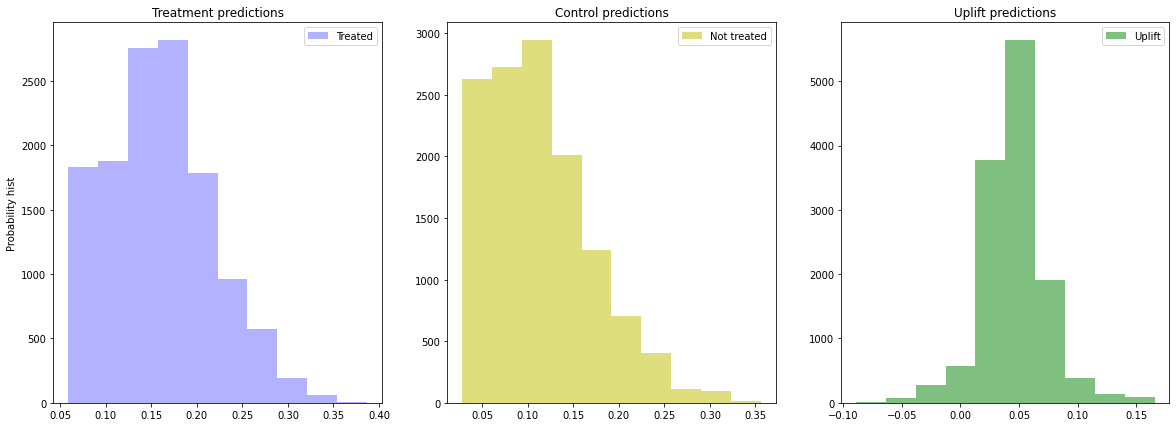

In [22]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

N =10000
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train.iloc[:N,:], y_train.iloc[:N], treat_train.iloc[:N], estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(   sm_trmnt_preds , sm_ctrl_preds, bins=10);#ctrl_preds=

Посмотрим на топ-признаки

In [23]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.746460
1,recency,18.955888
2,history,18.363622
3,treatment,15.099214
4,zip_code,13.021037
5,active user,7.583195
6,channel,6.230584


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

![ab_split](uplift5.png "uplift5")

![ab_split](uplift_client_types.png "uplift_client_types")

In [24]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

# ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

# models_results['approach'].append('ClassTransformation')
# models_results['uplift@30%'].append(ct_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


In [25]:
uplift_ct

array([-0.18997096, -0.25818462, -0.16227623, ..., -0.23870462,
       -0.1148874 , -0.165428  ])

#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

![ab_split](uplift6.png "uplift6")

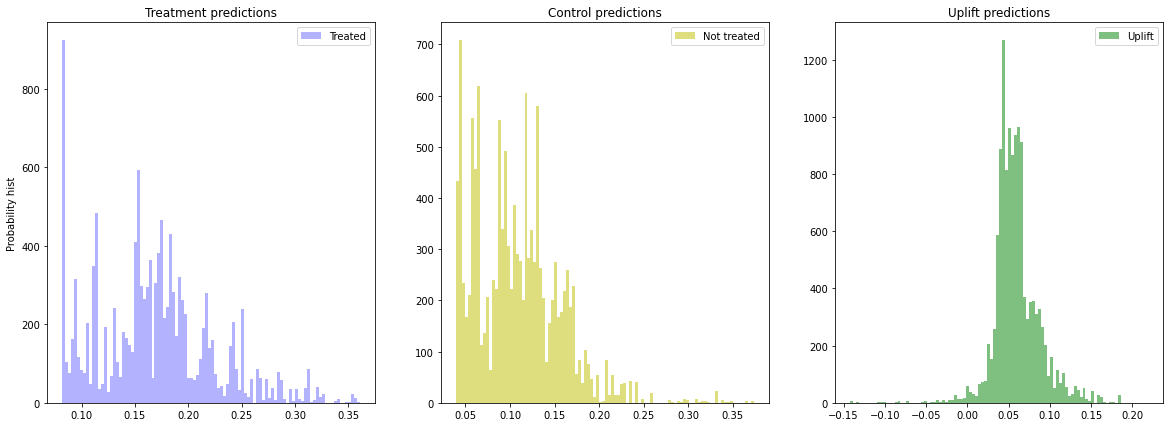

In [26]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [27]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.065775
1,TwoModels,0.049853


#### Вариант с деревом решений

In [29]:
X_train_tree = pd.concat([X_train.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_val_tree = pd.concat([X_val.drop('channel', 1), 
                          pd.get_dummies(X_val['channel'], prefix='channel')], 1)
X_val_tree = pd.concat([X_val.drop('zip_code', 1), 
                          pd.get_dummies(X_val['zip_code'], prefix='zip_code')], 1)
features = [col for col in X_train_tree]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


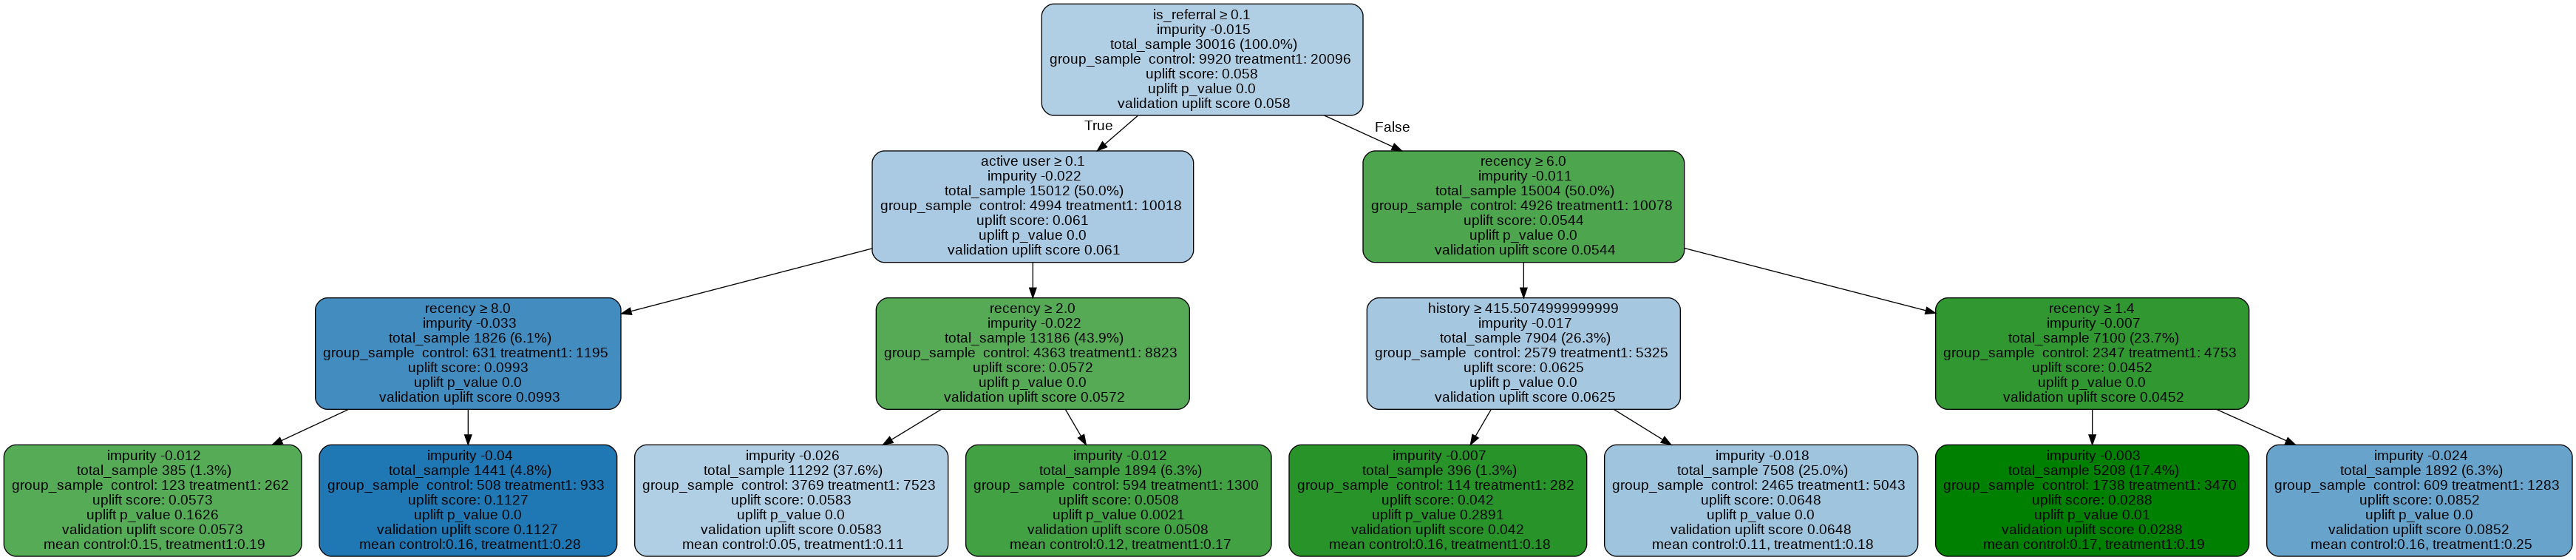

CPU times: user 3.2 s, sys: 344 ms, total: 3.54 s
Wall time: 6.21 s


In [30]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

In [31]:
import numpy as np
tree_lift =  np.array(uplift_model.predict(X_val_tree.values))[0]

uplift_tree_30 = uplift_at_k(y_val, tree_lift, treat_val, strategy='overall')
print(f'uplift@30%: {uplift_tree_30:.4f}')
models_results['approach'].append('TreeModels')
models_results['uplift@30%'].append(uplift_tree_30)

uplift@30%: 0.0598


In [36]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.065775
2,TreeModels,0.059811
1,TwoModels,0.049853


In [37]:
### ДЕРЕВО
# Лист, который  17%
# Фактически -это люди, которые пришли по реферральной программе, имели недавний контакт с магазином. 
# С высокой точностью можно утверждать, что воздействие на них приведет к желаемому резульату


### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html


### Библиотеки и пакеты

1. causalml
2. sklift
3. catboost